In [148]:
%config Completer.use_jedi = False

In [149]:
import logging
import warnings
from dataclasses import dataclass
from typing import Tuple

import seaborn as sns
import numpy as np
import pandas as pd
from scipy.linalg import eig
from scipy.optimize import fmin_bfgs
from scipy.spatial.distance import pdist


_required_opts = ['analytic', 'ntries']
_logger = logging.getLogger(__name__)


@dataclass
class PilotOutput:
    A: np.ndarray
    B: np.ndarray
    C: np.ndarray
    Z: np.ndarray
    error: float
    R2: np.ndarray


def errorfcn(alpha, Xbar, n, m):
    f1 = np.reshape(alpha[(2 * n):], (m, 2))
    f2 = np.reshape(alpha[0:2 * n], (2, n))
    f3 = Xbar[:, 0:n].T
    r = (Xbar - np.dot(f1, np.dot(f2, f3)).T) ** 2
    return np.nanmean(np.nanmean(r, axis=0))

def pilot(X, Y, featlabels=None, **kwargs):
    for opt in _required_opts:
        if opt not in kwargs:
            raise KeyError(f"Pilot required parameter {repr(opt)} missing.")

    Xbar = np.hstack((X, Y))
    n = X.shape[1]
    m = Xbar.shape[1]

    if kwargs['analytic']:
        _logger.info("PILOT is solving analyticaly the projection problem.")
        X = X.T
        Xbar = Xbar.T

        D, V = eig(np.dot(Xbar, Xbar.T), right=True, left=False)

        idx = np.argsort(np.abs(D))[::-1]
        V = V[:, idx[0:2]]
        B = V[0:n, :]
        C = V[n:m + 1, :].T
        Xr = np.dot(X.T, np.linalg.pinv(np.dot(X, X.T)))
        A = np.dot(V.T, np.dot(Xbar, Xr))
        Z = np.dot(A, X)
        Xhat = np.vstack((np.dot(B, Z), np.dot(C.T, Z)))
        error = float(np.sum((Xbar - Xhat) ** 2))
        R2 = np.diagonal(np.corrcoef(Xbar, Xhat, rowvar=False)[:m, m:]) ** 2
        Z = Z.T
    else:
        _logger.info("PILOT is solving numerically the projection problem.")
        ntries = kwargs['ntries']
        seed = kwargs['seed'] if 'seed' in kwargs else 1
        np.random.seed(seed)
        X0 = 2 * np.random.random((ntries, 2 * m + 2 * n)).T - 1
        alpha = np.zeros((2 * m + 2 * n, ntries))
        eoptim = np.zeros(ntries)
        perf = np.zeros(ntries)
        Hd = pdist(X)[np.newaxis].T

        for i in range(ntries):
            alpha[:, i], eoptim[i] = fmin_bfgs(lambda a: errorfcn(a, Xbar, n, m), x0=X0[:, i],
                                               full_output=True, disp=False)[:2]
#             print('shape alpha', alpha.shape, "alpha\n", alpha)
            aux = alpha[:, [i]]
            A = np.reshape(aux[0:2 * n], (2, n))
            Z = np.dot(X, A.T)
            perf[i] = np.corrcoef(Hd, pdist(Z)[np.newaxis].T, rowvar=False)[0][1]
            _logger.info(f"PILOT has completed trial {i+1}")

        idx = np.argmax(perf)
        A = np.reshape(alpha[0:2 * n, idx], (2, n))
        Z = np.dot(X, A.T)
        B = np.reshape(alpha[(2 * n):, idx], (m, 2))
        Xhat = np.dot(Z, B.T)
        C = B[n:m + 1, :].T
        B = B[0:n + 1, :]
        error = np.sum((Xbar - Xhat) ** 2)
        with warnings.catch_warnings(record=True) as w:
            R2 = np.diagonal(np.corrcoef(Xbar, Xhat, rowvar=False)[:m, m:]) ** 2

    out = PilotOutput(A, B, C, Z, error, R2)
    _logger.info("PILOT has completed.")
    return out


def adjust_rotation(Z: np.ndarray, Ybad: np.ndarray, theta: float = 135.0) -> Tuple[np.ndarray, np.ndarray]:
    cenroid_bad = np.mean(Z[Ybad], axis=0)[::-1]
    theta = np.radians(theta) - np.arctan2(*cenroid_bad)
    rot = np.array(((np.cos(theta), -np.sin(theta)),
                    (np.sin(theta), np.cos(theta))))
    Z_rot = np.dot(rot, Z.T)
    return Z_rot.T, rot


In [113]:
# df = pd.read_csv('datasets/5_dimension_pol1.csv')
# X = df.drop(columns = ['y'])
# Y = df[['y']]

In [156]:
df = pd.read_csv('datasets/compas_metadata.csv').drop(columns = ['instances'])
performance_columns = [col for col in df.columns if col.startswith('algo')]
X = df.drop(columns = performance_columns)
Y = df[performance_columns]

In [157]:
pilot_output = pilot(X, Y, analytic = False, ntries = 30)

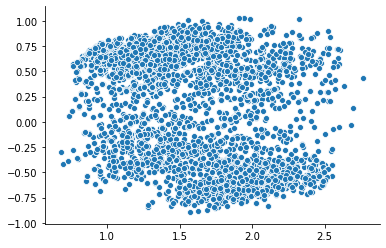

In [158]:
sns.scatterplot(x = pilot_output.Z[:, 0], y = pilot_output.Z[:, 1])
sns.despine()

In [159]:
pilot_output.error

3204.14503263242

## PCA

In [154]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state = 42)
pca.fit(df)
projection = pca.transform(df)

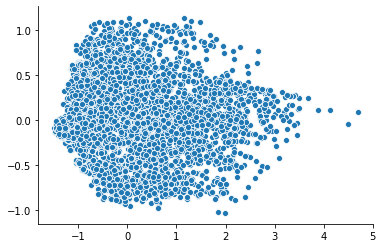

In [155]:
sns.scatterplot(x = projection[:, 0], y = projection[:, 1])
sns.despine()